In [21]:
import gdxpds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [22]:
scenarios = list(['nodal', 'with_instrument', 'without_instrument']);
nodes = list(['north', 'south'])

In [23]:
scenarios = list(['nodal', 'with_instrument', 'without_instrument', 'agnostic_instrument']);

nodes = list(['north', 'south'])

In [24]:
def read_data(file, indicator):
    gams_dir='C:\Program Files\GAMS'
    df = gdxpds.to_dataframes(str(file) + '.gdx', gams_dir=gams_dir)
    df = df[indicator]
    df['model'] = file
    if 'Level' in df.columns:
        df['Value'] = df['Level']
    df['Value'] = df['Value'].round(2)
    return(df.set_index(['model']))

def read(indicator):
    if (len(scenarios) == 4):
        df = read_data(scenarios[0], indicator).append(read_data(scenarios[1], indicator)).append(read_data(scenarios[2], indicator)).append(read_data(scenarios[3], indicator))
    elif (len(scenarios) == 3):
        df = read_data(scenarios[0], indicator).append(read_data(scenarios[1], indicator)).append(read_data(scenarios[2], indicator))
    return(df)
    
def plot_distribution(df, axes, location):
    
    width = 0.8
    #baseload
    
    tmp = df.loc[df['tec'] == 'base'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    leg = axes.barh(y_pos, tmp, width, align='center', color = 'darkred')
    left = tmp.fillna(0)

    #peaker
    tmp = df.loc[df['tec'] == 'peak'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'black')
    left = left + tmp.fillna(0)

    #wind
    tmp = df.loc[df['tec'] == 'wind'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'lightblue')
    left = left + tmp.fillna(0)

    #solar
    tmp = df.loc[df['tec'] == 'solar'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'gold')
    left = left + tmp.fillna(0)
    #leg.legend()
    return(axes)

    

In [6]:
df = read('o_gen')
df = df.reset_index().set_index(['model','t', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''

df = df.groupby(['model','tec']).sum()
df = df.reset_index().set_index(['model'])
gen = df

In [7]:
gen

,tec,north,south
model,,,
agnostic_instrument,base,167.85,311.35
agnostic_instrument,peak,5.34,58.24
agnostic_instrument,solar,0.00,31.75
agnostic_instrument,wind,50.19,26.51
nodal,base,27.38,306.67
nodal,peak,69.33,18.38
nodal,solar,0.00,32.52
nodal,wind,58.30,25.03
with_instrument,base,31.10,309.09


In [11]:
gen['total'] = gen['north'] + gen['south']

In [12]:
gen['type'] = ['RE' if tec in ['wind', 'solar'] else 'non RE' for tec in gen['tec']]

In [13]:
re_shares = gen[['total', 'type']].groupby(['model', 'type']).sum()

In [14]:
re_shares = re_shares.unstack()

In [15]:
re_shares

total        
type                     RE  non RE
model                              
agnostic_instrument  108.45  542.78
nodal                146.42  503.67
with_instrument      146.42  505.15
without_instrument   118.10  533.31

In [16]:
re_shares['total', 'RE'] / (re_shares['total', 'RE'] + re_shares['total', 'non RE'])

model
agnostic_instrument    0.166531
nodal                  0.225230
with_instrument        0.224719
without_instrument     0.181299
dtype: float64

In [17]:
sums = gen.groupby(['model']).sum()
sums['total'] = sums[nodes[0]] + sums[nodes[1]]
sums = sums /48 * 8760
sums['share north'] = sums[nodes[0]] / sums['total']
sums
# in GWh

,north,south,total,share north
model,,,,
agnostic_instrument,40766.850,78082.625,118849.475,0.343012
nodal,31917.425,86724.000,118641.425,0.269024
with_instrument,32623.700,86287.825,118911.525,0.274353
without_instrument,62179.575,56702.750,118882.325,0.523035


# Installed capacities

In [18]:
df = read('o_cap')
df = df.reset_index().set_index(['model', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''
df = df.reset_index().set_index(['model'])
capacities = df

In [19]:
capacities

,tec,north,south
model,,,
agnostic_instrument,base,14.57,26.41
agnostic_instrument,peak,1.04,12.89
agnostic_instrument,solar,NaN,21.17
agnostic_instrument,wind,20.40,12.87
nodal,base,2.05,32.71
nodal,peak,15.02,4.34
nodal,solar,5.98,19.46
nodal,wind,31.62,15.14
with_instrument,base,2.05,32.71


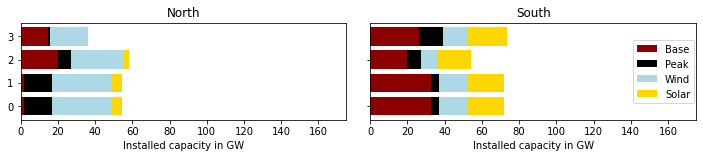

In [20]:
#plt.rcdefaults()
fig = plt.figure(figsize=(10, 2.3))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(capacities, ax1, 'north')
axes = plot_distribution(capacities, ax2, 'south')

ax1.set_xlim(0, 175)
ax2.set_xlim(0, 175)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.01, 0.87))
ax1.set_yticks(y_pos);

if len(scenarios) == 3:
    ax1.set_yticklabels(['First-best', 'Second-best', 'Reference scenario'])
ax2.set_yticklabels([]);
ax1.set_xlabel('Installed capacity in GW')
ax2.set_xlabel('Installed capacity in GW')
plt.tight_layout()

fig.savefig('Figures/capacity_distribution.jpeg', dpi=500)

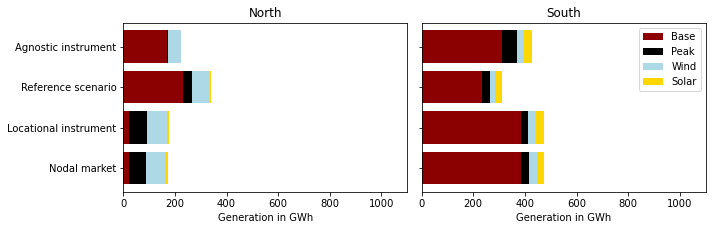

In [42]:
# plot generation
#plt.rcdefaults()
fig = plt.figure(figsize=(10, 3.3))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(gen, ax1, nodes[0])
axes = plot_distribution(gen, ax2, nodes[1])

ax1.set_xlim(0, 1100)
ax2.set_xlim(0, 1100)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.0, 1))
#ax1.legend(['Base', 'Peak', 'Wind', 'Solar'])
ax1.set_yticks(y_pos);

if len(scenarios) == 3:
    ax1.set_yticklabels(['Nodal market', 'Locational instrument', 'Reference scenario']);
    
if len(scenarios) == 4:
    ax1.set_yticklabels(['Nodal market', 'Locational instrument', 'Reference scenario', 'Agnostic instrument']);
    
ax2.set_yticklabels([]);
ax1.set_xlabel('Generation in GWh')
ax2.set_xlabel('Generation in GWh')
plt.tight_layout()

fig.savefig('generation_distribution.jpeg', dpi=500)

# Welfare comparison

In [22]:
welfare = pd.DataFrame(index = scenarios, columns = ['Network cost', 'Generation cost', 'Gross consumer surplus'])

In [23]:
for scenario in scenarios:
    welfare.loc[scenario, 'Network cost'] = read_data(scenario, 'network_cost').iloc[0,0]
    welfare.loc[scenario, 'Generation cost'] = read_data(scenario, 'generation_costs').iloc[0,0]
    welfare.loc[scenario, 'Gross consumer surplus'] = read_data(scenario, 'consumer_surplus').iloc[0,0]

In [24]:
welfare['Welfare'] = welfare['Gross consumer surplus'] - welfare['Network cost'] - welfare['Generation cost'];
#welfare['Welfare'] = welfare['Welfare']



In [25]:
welfare = welfare / 1000

In [26]:
welfare.style.format('{0:,.2f}')

,Network cost,Generation cost,Gross consumer surplus,Welfare
nodal,1.50,49.41,401.21,350.30
with_instrument,1.60,49.52,401.42,350.30
without_instrument,4.01,49.72,401.33,347.59
agnostic_instrument,2.45,49.82,401.33,349.06


In [27]:
print('welfare gains through instrument in %')
    
print(round((welfare['Welfare']['with_instrument'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,6))

print('welfare gains through nodal pricing in %')
    
print(round((welfare['Welfare']['nodal'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,6))

if len(scenarios) > 3:
    print('welfare gain through uniform signal in %')
    print(round((welfare['Welfare']['agnostic_instrument'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['with_instrument'] * 100,2))


welfare gains through instrument in %
0.778697
welfare gains through nodal pricing in %
0.7787
welfare gain through uniform signal in %
0.42


# Instrument level

In [28]:
fixed_costs = read_data('with_instrument', 'c_fix').reset_index(drop = True).set_index(['tec','n']).unstack()
fixed_costs.columns = fixed_costs.columns.droplevel(0)

In [29]:
fixed_costs

n,north,south
tec,,
base,411.0,411.0
peak,151.0,151.0
solar,82.0,82.0
wind,137.0,137.0


In [30]:
instr = read_data('with_instrument', 'o_instrument').reset_index(drop = True).set_index(['tec','n']).unstack()
instr.columns = instr.columns.droplevel(0)
instr = instr.round(1)

In [31]:
instr

n,north,south
tec,,
base,11.3,1.1
peak,-22.2,-18.7
solar,4.4,8.7
wind,7.8,-1.5


In [32]:
cap = read_data('with_instrument', 'o_cap').reset_index(drop = True).set_index(['tec','n']).unstack()
cap.columns = cap.columns.droplevel(0)
instr[cap.isna()] = np.nan

In [33]:
shares = round(100 *instr / fixed_costs,1)

In [34]:
shares = shares.rename(columns={'north':'north (share)', 'south': 'south (share)'})
#shares.columns = shares.columns.droplevel(0)

In [35]:
shares

n,north (share),south (share)
tec,,
base,2.7,0.3
peak,-14.7,-12.4
solar,5.4,10.6
wind,5.7,-1.1


In [36]:
instrument = pd.concat([instr, shares], axis=1)
instrument = instrument.sort_index(axis = 1)

In [37]:
#fixed_costs.columns = fixed_costs.columns.droplevel(0)
instrument['Fixed cost'] = fixed_costs['north']

In [38]:
format_dict = {'north':'{0:,.0f} €', 'north (share)': '{0:,.0f}%', 'south': '{0:,.0f} €', 'south (share)': '{0:,.0f}%', 'Fixed cost': '{0:,.0f} €'}
instrument.style.format(format_dict)

n,north,north (share),south,south (share),Fixed cost
tec,,,,,
base,11 €,3%,1 €,0%,411 €
peak,-22 €,-15%,-19 €,-12%,151 €
solar,4 €,5%,9 €,11%,82 €
wind,8 €,6%,-2 €,-1%,137 €


In [39]:
instr

n,north,south
tec,,
base,11.3,1.1
peak,-22.2,-18.7
solar,4.4,8.7
wind,7.8,-1.5


# Redispatch

In [25]:
cap = read_data('with_instrument', 'o_cap')

In [26]:
cap2 = read_data('with_instrument_redispatch', 'o_cap')

In [27]:
cap

,tec,n,Value
model,,,
with_instrument,base,north,3.11
with_instrument,base,south,31.50
with_instrument,peak,north,15.39
with_instrument,peak,south,3.54
with_instrument,wind,north,27.76
with_instrument,wind,south,14.22
with_instrument,solar,north,0.00
with_instrument,solar,south,27.32


In [28]:
cap2

,tec,n,Value
model,,,
with_instrument_redispatch,base,north,3.83
with_instrument_redispatch,base,south,30.68
with_instrument_redispatch,peak,north,13.01
with_instrument_redispatch,peak,south,5.89
with_instrument_redispatch,wind,north,30.94
with_instrument_redispatch,wind,south,13.00
with_instrument_redispatch,solar,north,0.00
with_instrument_redispatch,solar,south,18.22


In [29]:
dif = cap2.set_index(['tec', 'n']) - cap.set_index(['tec', 'n'])

In [30]:
dif

Value
tec   n           
base  north   0.72
      south  -0.82
peak  north  -2.38
      south   2.35
wind  north   3.18
      south  -1.22
solar north   0.00
      south  -9.10